In [8]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

In [9]:
loans = joblib.load("../data/final_model_data.joblib")

In [10]:
loans.head()

,loan_amnt,term,emp_length,home_ownership,annual_inc,purpose,dti,delinq_2yrs,cr_hist_age_mths,fico_range_low,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,recovered_percentage,issue_d,grade,sub_grade,expected_return,date
1909203,2125.0,36 months,3 years,MORTGAGE,45000.0,home_improvement,15.88,1.0,137.0,660.0,...,146436.0,23662.0,3200.0,22483.0,1.000000,Aug-2012,C,C5,2737.80,2012-08-01
1909437,28000.0,60 months,10+ years,MORTGAGE,150000.0,debt_consolidation,5.96,1.0,198.0,685.0,...,417242.0,27924.0,31432.0,25523.0,0.446871,Aug-2012,E,E4,46381.20,2012-08-01
1909457,14125.0,36 months,3 years,RENT,36000.0,debt_consolidation,18.93,0.0,107.0,665.0,...,58087.0,57612.0,7900.0,47687.0,1.000000,Aug-2012,D,D3,18575.64,2012-08-01
1909558,16000.0,60 months,10+ years,RENT,58900.0,debt_consolidation,33.53,0.0,141.0,700.0,...,83557.0,69752.0,1800.0,69657.0,0.327324,Aug-2012,E,E1,25696.80,2012-08-01
1909566,2800.0,36 months,4 years,RENT,89000.0,debt_consolidation,15.18,0.0,295.0,670.0,...,51892.0,50262.0,2500.0,44992.0,1.000000,Aug-2012,C,C2,3509.64,2012-08-01


In [11]:
train, test = train_test_split(loans, test_size=0.2, shuffle=False)
train_nn, train_xgb, test_nn, test_xgb = train.copy(), train.copy(), test.copy(), test.copy()
print(f"The test set contains {len(test):,} loans.")

onehot_cols = ["term", "application_type", "home_ownership", "purpose"]
ordinal_cols = {
    "emp_length": [
        "< 1 year",
        "1 year",
        "2 years",
        "3 years",
        "4 years",
        "5 years",
        "6 years",
        "7 years",
        "8 years",
        "9 years",
        "10+ years",
    ]
}

The test set contains 222,035 loans.


In [12]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

def run_pipeline_cv(data, onehot_cols, ordinal_cols, model_type="nn", batch_size=None):
    X = data.drop(columns=["recovered_percentage"])
    y = data["recovered_percentage"]

    transformer = DataFrameMapper(
        [
            (onehot_cols, OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
            (
                list(ordinal_cols.keys()),
                OrdinalEncoder(categories=list(ordinal_cols.values())),
            ),
        ],
        default=StandardScaler(),
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    history_list = []
    model_list = []
    transformer_list = []

    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        X_train = transformer.fit_transform(X_train)
        X_valid = transformer.transform(X_valid)

        if model_type == "nn":
            input_nodes = X_train.shape[1]
            output_nodes = 1

            learning_rate = 0.002
            momentum = 0.9
            optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

            reg_strength = 0.001  # Set regularization strength
            regularizer = l2(reg_strength)  # Create an L2 regularizer

            model = Sequential()
            model.add(Input((input_nodes,)))
            model.add(Dense(64, activation="relu", kernel_regularizer=regularizer))
            model.add(Dropout(0.3, seed=0))
            model.add(Dense(32, activation="relu", kernel_regularizer=regularizer))
            model.add(Dropout(0.3, seed=1))
            model.add(Dense(16, activation="relu", kernel_regularizer=regularizer))
            model.add(Dropout(0.3, seed=2))
            model.add(Dense(output_nodes, kernel_regularizer=regularizer))
            model.compile(optimizer=optimizer, loss="mean_squared_logarithmic_error")

            history = model.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=100,
                validation_data=(X_valid, y_valid),
                verbose=2,
            )
            history_list.append(history.history)
        elif model_type == "xgb":
            model = XGBRegressor(objective="reg:squarederror")

            # param_grid = {
            #     'max_depth': [3, 5, 7],
            #     'learning_rate': [0.1, 0.01, 0.001],
            #     # Add more hyperparameters and their values as needed
            # }
            #
            # grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error')
            model.fit(X_train, y_train)

            # best_params = grid_search.best_params_
            # best_model = grid_search.best_estimator_

            # model = best_model
            history_list.append(None)

        model_list.append(model)
        transformer_list.append(transformer)

    return history_list, model_list, transformer_list

In [13]:
def make_predictions(data, model_list, transformer_list):
    predictions_list = []

    for i in range(len(model_list)):
        model = model_list[i]
        transformer = transformer_list[i]

        X_test = transformer.transform(
            data.drop(
                columns=[
                    "recovered_percentage",
                    "issue_d",
                    "date",
                    "grade",
                    "sub_grade",
                    "expected_return",
                ]
            )
        )

        predictions = model.predict(X_test)
        predictions_list.append(predictions)

    data["model_predictions"] = np.mean(predictions_list, axis=0)

In [14]:
# Run the pipeline with cross-validation for neural network
nn_history_list, nn_model_list, nn_transformer_list = run_pipeline_cv(
    train_nn.drop(columns=["issue_d", "date", "grade", "sub_grade", "expected_return"]),
    onehot_cols,
    ordinal_cols,
    model_type="nn",
    batch_size=128,
)

# Make predictions for neural network
make_predictions(test_nn, nn_model_list, nn_transformer_list)

Epoch 1/100
5551/5551 - 3s - loss: 0.1361 - val_loss: 0.1086 - 3s/epoch - 503us/step
Epoch 2/100
5551/5551 - 2s - loss: 0.0920 - val_loss: 0.0777 - 2s/epoch - 449us/step
Epoch 3/100
5551/5551 - 2s - loss: 0.0670 - val_loss: 0.0579 - 2s/epoch - 439us/step
Epoch 4/100
5551/5551 - 2s - loss: 0.0511 - val_loss: 0.0452 - 2s/epoch - 439us/step
Epoch 5/100
5551/5551 - 2s - loss: 0.0408 - val_loss: 0.0371 - 2s/epoch - 438us/step
Epoch 6/100
5551/5551 - 3s - loss: 0.0342 - val_loss: 0.0318 - 3s/epoch - 456us/step
Epoch 7/100
5551/5551 - 3s - loss: 0.0300 - val_loss: 0.0284 - 3s/epoch - 476us/step
Epoch 8/100
5551/5551 - 3s - loss: 0.0273 - val_loss: 0.0262 - 3s/epoch - 466us/step
Epoch 9/100
5551/5551 - 2s - loss: 0.0255 - val_loss: 0.0248 - 2s/epoch - 450us/step
Epoch 10/100
5551/5551 - 2s - loss: 0.0244 - val_loss: 0.0238 - 2s/epoch - 438us/step
Epoch 11/100
5551/5551 - 2s - loss: 0.0236 - val_loss: 0.0231 - 2s/epoch - 438us/step
Epoch 12/100
5551/5551 - 2s - loss: 0.0231 - val_loss: 0.0227 -

Epoch 1/100
5551/5551 - 3s - loss: 0.1410 - val_loss: 0.1078 - 3s/epoch - 484us/step
Epoch 2/100
5551/5551 - 3s - loss: 0.0912 - val_loss: 0.0772 - 3s/epoch - 463us/step
Epoch 3/100
5551/5551 - 3s - loss: 0.0666 - val_loss: 0.0576 - 3s/epoch - 456us/step
Epoch 4/100
5551/5551 - 3s - loss: 0.0508 - val_loss: 0.0450 - 3s/epoch - 484us/step
Epoch 5/100
5551/5551 - 3s - loss: 0.0406 - val_loss: 0.0370 - 3s/epoch - 460us/step
Epoch 6/100
5551/5551 - 3s - loss: 0.0341 - val_loss: 0.0318 - 3s/epoch - 467us/step
Epoch 7/100
5551/5551 - 3s - loss: 0.0299 - val_loss: 0.0284 - 3s/epoch - 455us/step
Epoch 8/100
5551/5551 - 3s - loss: 0.0272 - val_loss: 0.0262 - 3s/epoch - 468us/step
Epoch 9/100
5551/5551 - 2s - loss: 0.0255 - val_loss: 0.0248 - 2s/epoch - 433us/step
Epoch 10/100
5551/5551 - 2s - loss: 0.0244 - val_loss: 0.0239 - 2s/epoch - 427us/step
Epoch 11/100
5551/5551 - 2s - loss: 0.0237 - val_loss: 0.0233 - 2s/epoch - 435us/step
Epoch 12/100
5551/5551 - 3s - loss: 0.0232 - val_loss: 0.0229 -

Epoch 1/100
5551/5551 - 3s - loss: 0.1409 - val_loss: 0.1077 - 3s/epoch - 527us/step
Epoch 2/100
5551/5551 - 3s - loss: 0.0915 - val_loss: 0.0770 - 3s/epoch - 472us/step
Epoch 3/100
5551/5551 - 3s - loss: 0.0667 - val_loss: 0.0574 - 3s/epoch - 466us/step
Epoch 4/100
5551/5551 - 3s - loss: 0.0509 - val_loss: 0.0449 - 3s/epoch - 490us/step
Epoch 5/100
5551/5551 - 3s - loss: 0.0408 - val_loss: 0.0368 - 3s/epoch - 477us/step
Epoch 6/100
5551/5551 - 3s - loss: 0.0343 - val_loss: 0.0317 - 3s/epoch - 475us/step
Epoch 7/100
5551/5551 - 3s - loss: 0.0301 - val_loss: 0.0284 - 3s/epoch - 484us/step
Epoch 8/100
5551/5551 - 3s - loss: 0.0274 - val_loss: 0.0263 - 3s/epoch - 494us/step
Epoch 9/100
5551/5551 - 3s - loss: 0.0257 - val_loss: 0.0249 - 3s/epoch - 456us/step
Epoch 10/100
5551/5551 - 3s - loss: 0.0246 - val_loss: 0.0240 - 3s/epoch - 470us/step
Epoch 11/100
5551/5551 - 3s - loss: 0.0239 - val_loss: 0.0234 - 3s/epoch - 462us/step
Epoch 12/100
5551/5551 - 3s - loss: 0.0234 - val_loss: 0.0230 -

Epoch 1/100
5551/5551 - 3s - loss: 0.1418 - val_loss: 0.1088 - 3s/epoch - 463us/step
Epoch 2/100
5551/5551 - 2s - loss: 0.0921 - val_loss: 0.0778 - 2s/epoch - 424us/step
Epoch 3/100
5551/5551 - 2s - loss: 0.0671 - val_loss: 0.0580 - 2s/epoch - 426us/step
Epoch 4/100
5551/5551 - 2s - loss: 0.0511 - val_loss: 0.0453 - 2s/epoch - 422us/step
Epoch 5/100
5551/5551 - 2s - loss: 0.0409 - val_loss: 0.0372 - 2s/epoch - 424us/step
Epoch 6/100
5551/5551 - 2s - loss: 0.0343 - val_loss: 0.0320 - 2s/epoch - 426us/step
Epoch 7/100
5551/5551 - 2s - loss: 0.0301 - val_loss: 0.0287 - 2s/epoch - 428us/step
Epoch 8/100
5551/5551 - 2s - loss: 0.0274 - val_loss: 0.0265 - 2s/epoch - 423us/step
Epoch 9/100
5551/5551 - 2s - loss: 0.0257 - val_loss: 0.0252 - 2s/epoch - 423us/step
Epoch 10/100
5551/5551 - 2s - loss: 0.0246 - val_loss: 0.0243 - 2s/epoch - 422us/step
Epoch 11/100
5551/5551 - 2s - loss: 0.0239 - val_loss: 0.0237 - 2s/epoch - 426us/step
Epoch 12/100
5551/5551 - 2s - loss: 0.0234 - val_loss: 0.0233 -

Epoch 1/100
5551/5551 - 3s - loss: 0.1375 - val_loss: 0.1084 - 3s/epoch - 459us/step
Epoch 2/100
5551/5551 - 2s - loss: 0.0919 - val_loss: 0.0775 - 2s/epoch - 426us/step
Epoch 3/100
5551/5551 - 2s - loss: 0.0670 - val_loss: 0.0578 - 2s/epoch - 425us/step
Epoch 4/100
5551/5551 - 2s - loss: 0.0511 - val_loss: 0.0451 - 2s/epoch - 425us/step
Epoch 5/100
5551/5551 - 2s - loss: 0.0408 - val_loss: 0.0369 - 2s/epoch - 424us/step
Epoch 6/100
5551/5551 - 2s - loss: 0.0342 - val_loss: 0.0317 - 2s/epoch - 424us/step
Epoch 7/100
5551/5551 - 2s - loss: 0.0300 - val_loss: 0.0283 - 2s/epoch - 421us/step
Epoch 8/100
5551/5551 - 2s - loss: 0.0273 - val_loss: 0.0261 - 2s/epoch - 425us/step
Epoch 9/100
5551/5551 - 2s - loss: 0.0256 - val_loss: 0.0247 - 2s/epoch - 424us/step
Epoch 10/100
5551/5551 - 2s - loss: 0.0244 - val_loss: 0.0238 - 2s/epoch - 425us/step
Epoch 11/100
5551/5551 - 2s - loss: 0.0237 - val_loss: 0.0232 - 2s/epoch - 422us/step
Epoch 12/100
5551/5551 - 2s - loss: 0.0232 - val_loss: 0.0228 -

In [15]:
# Run the pipeline with cross-validation for XGBoost
xgb_history_list, xgb_model_list, xgb_transformer_list = run_pipeline_cv(
    train_xgb.drop(columns=["issue_d", "date", "grade", "sub_grade", "expected_return"]),
    onehot_cols,
    ordinal_cols,
    model_type="xgb",
)

# Make predictions for XGBoost
make_predictions(test_xgb, xgb_model_list, xgb_transformer_list)

In [16]:
# Define the weights for each model
xgb_weight = 0.8
nn_weight = 0.2

# Calculate the weighted average of the predictions
test["model_predictions"] = (xgb_weight * test_xgb["model_predictions"]) + (nn_weight * test_nn["model_predictions"])

In [17]:
import joblib

# Save the neural network models and data transformers
for i, model in enumerate(nn_model_list):
    model.save(f"./linear/nn_loan_risk_model_{i}")
joblib.dump(nn_transformer_list, "./linear/nn_data_transformer.joblib")

# Save the XGBoost models and data transformers
for i, model in enumerate(xgb_model_list):
    model.save_model(f"./linear/xgb_loan_risk_model_{i}.json")
joblib.dump(xgb_transformer_list, "./linear/xgb_data_transformer.joblib")


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_0/assets


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_0/assets


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_1/assets


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_1/assets


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_2/assets


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_2/assets


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_3/assets


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_3/assets


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_4/assets


INFO:tensorflow:Assets written to: ./linear/nn_loan_risk_model_4/assets


['./linear/xgb_data_transformer.joblib']

In [18]:
def compare_models(test):
    loan_grades=["A", "B", "C", "D", "E", "F", "G"]
    model_predictions = "model_predictions"
    recovered_percentage = "recovered_percentage"
    lc_prefix = "lc_"
    ty_prefix = "ty_"
    results = {}

    start_index = 0
    for grade in loan_grades:
        lc_grade = test[test["grade"] == grade]
        lc_grade_avg = round(np.mean(lc_grade[recovered_percentage]), 5)
        lc_key = lc_prefix + grade.lower()
        results[lc_key] = lc_grade_avg

        ty_grade = test.sort_values(model_predictions, axis="index", ascending=False).iloc[
            start_index : len(lc_grade) + start_index
        ]
        start_index += len(lc_grade)
        ty_grade_avg = round(np.mean(ty_grade[recovered_percentage]), 5)
        ty_key = ty_prefix + grade.lower()
        results[ty_key] = ty_grade_avg

        print(f"LendingClub gave {len(lc_grade):,} loans in the test set a(n) {grade} grade")
        print(f"Average `recovered_percentage` on LendingClub's grade {grade} loans: {lc_grade_avg}")
        print(f"Average `recovered_percentage` on Ty's grade {grade} loans (with cross-validation): {ty_grade_avg}")

    return results

results = compare_models(test)
print(results)

LendingClub gave 38,779 loans in the test set a(n) A grade
Average `recovered_percentage` on LendingClub's grade A loans: 0.96021
Average `recovered_percentage` on Ty's grade A loans (with cross-validation): 0.96393
LendingClub gave 61,844 loans in the test set a(n) B grade
Average `recovered_percentage` on LendingClub's grade B loans: 0.90378
Average `recovered_percentage` on Ty's grade B loans (with cross-validation): 0.90904
LendingClub gave 69,218 loans in the test set a(n) C grade
Average `recovered_percentage` on LendingClub's grade C loans: 0.82924
Average `recovered_percentage` on Ty's grade C loans (with cross-validation): 0.8382
LendingClub gave 33,142 loans in the test set a(n) D grade
Average `recovered_percentage` on LendingClub's grade D loans: 0.76535
Average `recovered_percentage` on Ty's grade D loans (with cross-validation): 0.75927
LendingClub gave 12,654 loans in the test set a(n) E grade
Average `recovered_percentage` on LendingClub's grade E loans: 0.70825
Average

In [19]:
from sklearn.metrics import mean_absolute_error

# MAE
mae = mean_absolute_error(test["recovered_percentage"], test["model_predictions"])
print("MAE:")
print(round(mae, 5))

MAE:
0.19773


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# Calculate MAE
nn_mae = mean_absolute_error(test["recovered_percentage"], test_nn["model_predictions"])
xgb_mae = mean_absolute_error(test["recovered_percentage"], test_xgb["model_predictions"])
resembled_mae = mean_absolute_error(test["recovered_percentage"], test["model_predictions"])

# Calculate MSLE
nn_msle = mean_squared_log_error(test["recovered_percentage"], test_nn["model_predictions"])
xgb_msle = mean_squared_log_error(test["recovered_percentage"], test_xgb["model_predictions"])
resembled_msle = mean_squared_log_error(test["recovered_percentage"], test["model_predictions"])

# Print the results
print("Mean Absolute Error (MAE):")
print("NN:", nn_mae)
print("XGB:", xgb_mae)
print("Resembled Model:", resembled_mae)

print("\nMean Squared Logarithmic Error (MSLE):")
print("NN:", nn_msle)
print("XGB:", xgb_msle)
print("Resembled Model:", resembled_msle)

Mean Absolute Error (MAE):
NN: 0.2145914033784003
XGB: 0.19391137497169417
Resembled Model: 0.19773290933908785

Mean Squared Logarithmic Error (MSLE):
NN: 0.03701368412792816
XGB: 0.0360133317734743
Resembled Model: 0.036069431401593695


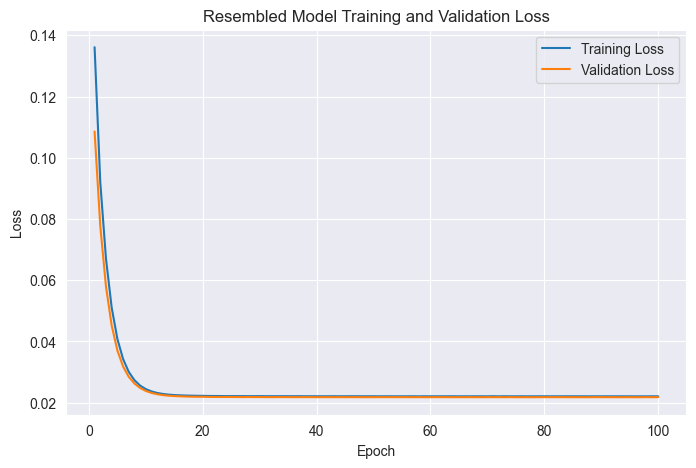

In [21]:
import matplotlib.pyplot as plt

# Extract loss values from the Resembled Model history
resembled_train_loss = nn_history_list[0]['loss']  # Replace with the actual training loss values
resembled_val_loss = nn_history_list[0]['val_loss']  # Replace with the actual validation loss values

# Plot loss function for the Resembled Model
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(resembled_train_loss) + 1), resembled_train_loss, label='Training Loss')
plt.plot(range(1, len(resembled_val_loss) + 1), resembled_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Resembled Model Training and Validation Loss')
plt.legend()
plt.show()


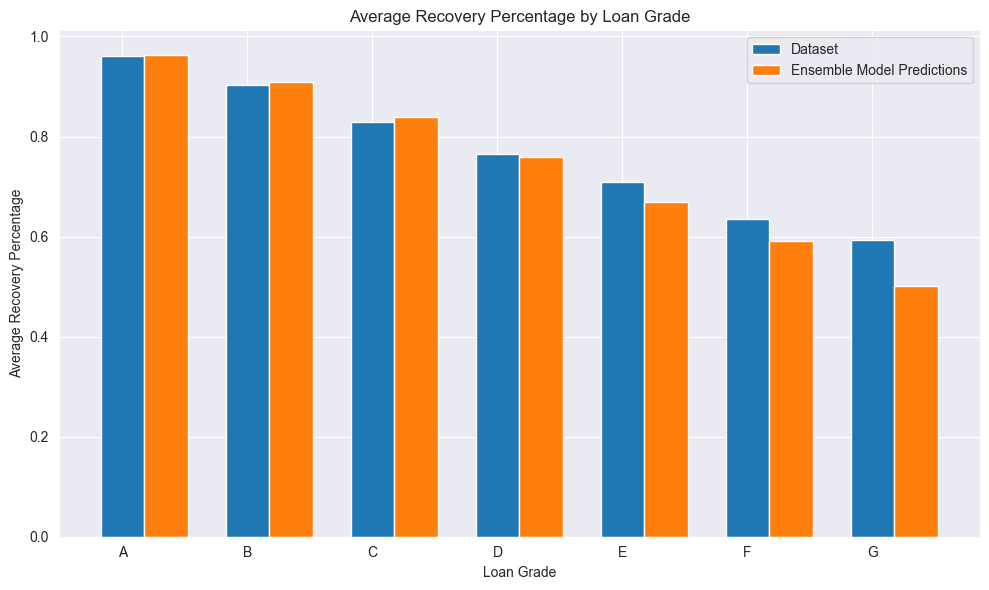

In [22]:
import matplotlib.pyplot as plt

loan_grades=["A", "B", "C", "D", "E", "F", "G"]
model_predictions = "model_predictions"
recovered_percentage = "recovered_percentage"

# Calculate the average recovery percentage for each loan grade in the dataset
dataset_grade_avg = [results["lc_" + grade.lower()] for grade in loan_grades]

# Calculate the average recovery percentage for each loan grade in the ensemble model predictions
ensemble_grade_avg = [results["ty_" + grade.lower()] for grade in loan_grades]

# Set the width of the bars
bar_width = 0.35

# Set the x positions of the bars
bar_positions = range(len(loan_grades))

# Plot the average recovery percentages
plt.figure(figsize=(10, 6))
plt.bar(bar_positions, dataset_grade_avg, width=bar_width, label="Dataset")
plt.bar([pos + bar_width for pos in bar_positions], ensemble_grade_avg, width=bar_width, label="Ensemble Model Predictions")

# Add labels, title, and legend
plt.xlabel("Loan Grade")
plt.ylabel("Average Recovery Percentage")
plt.title("Average Recovery Percentage by Loan Grade")
plt.xticks(bar_positions, loan_grades)
plt.legend()

# Adjust the layout to prevent overlapping of bars and labels
plt.tight_layout()

# Show the plot
plt.show()
